In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model, Model
from keras.layers import Dense, Dropout, LSTM, Input, RepeatVector, TimeDistributed, Flatten


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [0]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = '/content/drive/My Drive/Fax/Master Theses/output-simpler lstm/regression_model.h5'
model_path2 = '/content/drive/My Drive/Fax/Master Theses/output-simpler lstm 100/regression_model-100.h5'
model_path3 = '/content/drive/My Drive/Fax/Master Theses/output-simpler lstm 50 i droput/regression_model.h5'

model_path_encoder = '/content/drive/My Drive/Fax/Master Theses/output-simpler lstm/encoder_model.h5'
output_path ='/content/drive/My Drive/Fax/Master Theses/output-simpler lstm'
output_path2 ='/content/drive/My Drive/Fax/Master Theses/output-simpler lstm 100'
output_path3 ='/content/drive/My Drive/Fax/Master Theses/output-simpler lstm 50 i droput'


In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('../../Dataset/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)

In [33]:
######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)


   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [34]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

142
(15631, 50, 25)


(15631, 1)

In [0]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
##################################
# Autoencoder
##################################

def autoencoder(data, latent_dim = 14):

  n_samples = data.shape[0]
  timesteps = data.shape[1]
  n_features = data.shape[2]
  #n_samples x timesteps x n_features

  inputs = Input(shape=(timesteps, n_features))
  encoded = LSTM(latent_dim)(inputs)

  decoded = RepeatVector(timesteps)(encoded)
  decoded = LSTM(n_features, return_sequences=True)(decoded)

  sequence_autoencoder = Model(inputs, decoded)

  sequence_autoencoder.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

  print(sequence_autoencoder.summary())

  # fit the network
  history = sequence_autoencoder.fit(seq_array, seq_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                        keras.callbacks.ModelCheckpoint(model_path_encoder,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
            )
  

  # make model for encoder only 
  model = Model(inputs=sequence_autoencoder.inputs, outputs=sequence_autoencoder.layers[2].output)
    
  return model

In [0]:
encoder_model = autoencoder(seq_array)
encoded_data = encoder_model.predict(seq_array,verbose=1, batch_size=200)
#encoded_data = encoded_data.reshape( encoded_data.shape[0],1, encoded_data.shape[1])





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 25)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14)                2240      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 50, 14)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 25)            4000      
Total params: 6,240
Trainable params: 6,240
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 14849 samples, validate on 782 samples
Epoch 1/100





 - 9s - loss: 0.0431 - mean_absolute_error: 0.1386 - r2_keras: 0.4239 - val_loss: 0.

In [0]:

#if os.path.isfile(model_path_encoder):
#    autoencoder_model = load_model(model_path_encoder,custom_objects={'r2_keras': r2_keras})
#    estimator_encoder = Model(inputs=autoencoder_model.inputs, outputs=autoencoder_model.layers[2].output)

    

#    encoded_data = estimator_encoder.predict(seq_array,verbose=1, batch_size=200)

15631/15631 [==============================] - 1s 67us/step


In [0]:
encoded_data.shape

(15631, 50, 14)

In [0]:
##################################
# Modeling
##################################


timesteps = encoded_data.shape[1]
nb_features = encoded_data.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(timesteps, nb_features),
         units=50,
         return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(encoded_data, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________
None
Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 7s - loss: 9146.4751 - mean_absolute_error: 77.0815 - r2_keras: -1.8237e+00 - val_loss: 8425.9079 - val_mean_absolute_error: 73.4337 - val_r2_keras: -2.5824e+00
Epoch 2/100
 - 5s - loss: 8333.7797 - mean_absolute_error: 72.3755 - r2_keras: -1.5691e+00 - val_loss: 7897.8559 - val_mean_absolute_error: 70.3590 - v

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_r2_keras', 'loss', 'mean_absolute_error', 'r2_keras'])


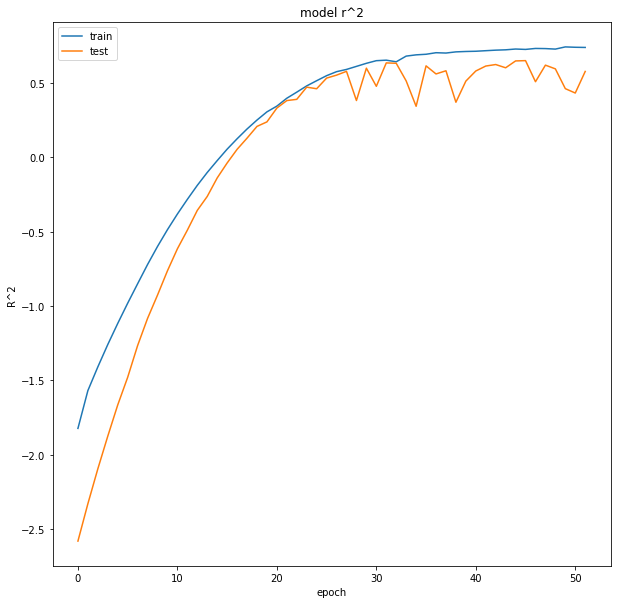

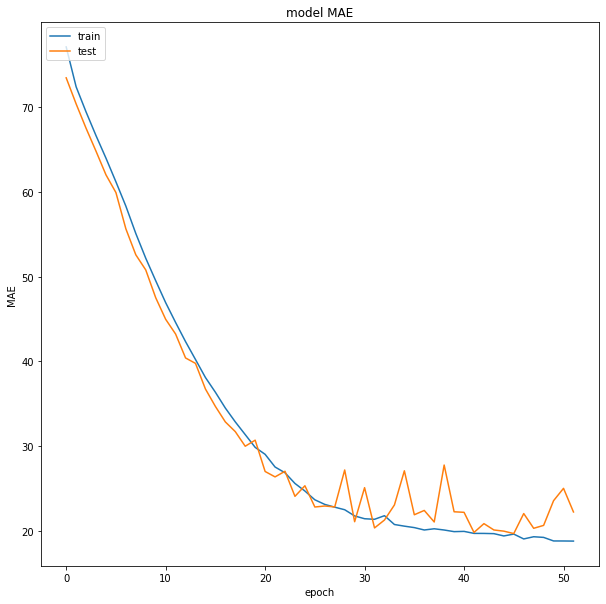

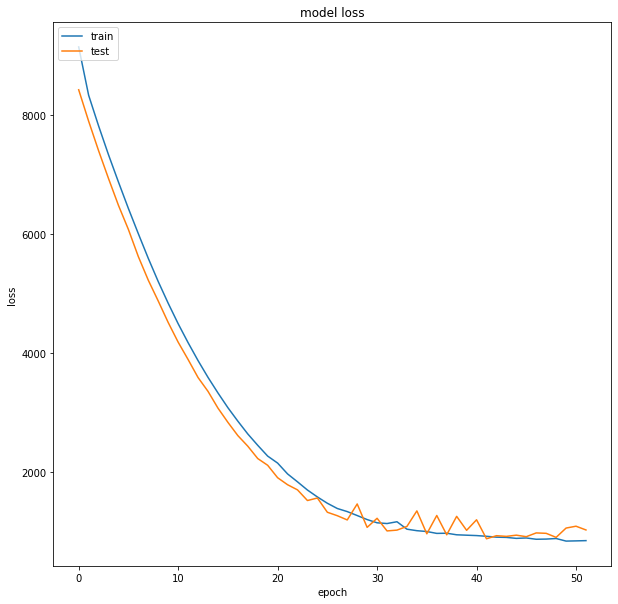

15631/15631 [==============================] - 2s 100us/step

MAE: 19.535699162676316

R^2: 0.6998473965506218
15631/15631 [==============================] - 2s 116us/step


In [0]:

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_regression_loss.png")

# training metrics
scores = model.evaluate(encoded_data, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(encoded_data,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv(output_path+'/submit_train.csv', index = None)


In [0]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)



seq_array_test_last
(93, 50, 25)
(93, 1)


In [0]:
#encode test data

if os.path.isfile(model_path_encoder):
    autoencoder_model = load_model(model_path_encoder,custom_objects={'r2_keras': r2_keras})
    estimator_encoder = Model(inputs=autoencoder_model.inputs, outputs=autoencoder_model.layers[2].output)

    encoded_data_test = estimator_encoder.predict(seq_array_test_last,verbose=1, batch_size=200)
    encoded_data_test.shape

93/93 [==============================] - 0s 4ms/step


In [0]:
#encode test data

if os.path.isfile(model_path_encoder):
    autoencoder_model = load_model(model_path_encoder,custom_objects={'r2_keras': r2_keras})
    #estimator_encoder = Model(inputs=autoencoder_model.inputs, outputs=autoencoder_model.layers[2].output)

    encoded_data_test = autoencoder_model.predict(seq_array_test_last,verbose=1, batch_size=200)
    encoded_data_test.shape

93/93 [==============================] - 0s 4ms/step


In [0]:
encoded_data_test.shape
#estimator_encoder.summary()

(93, 50, 14)


MAE: 15.400349206821893

R^2: 0.6912001980248318


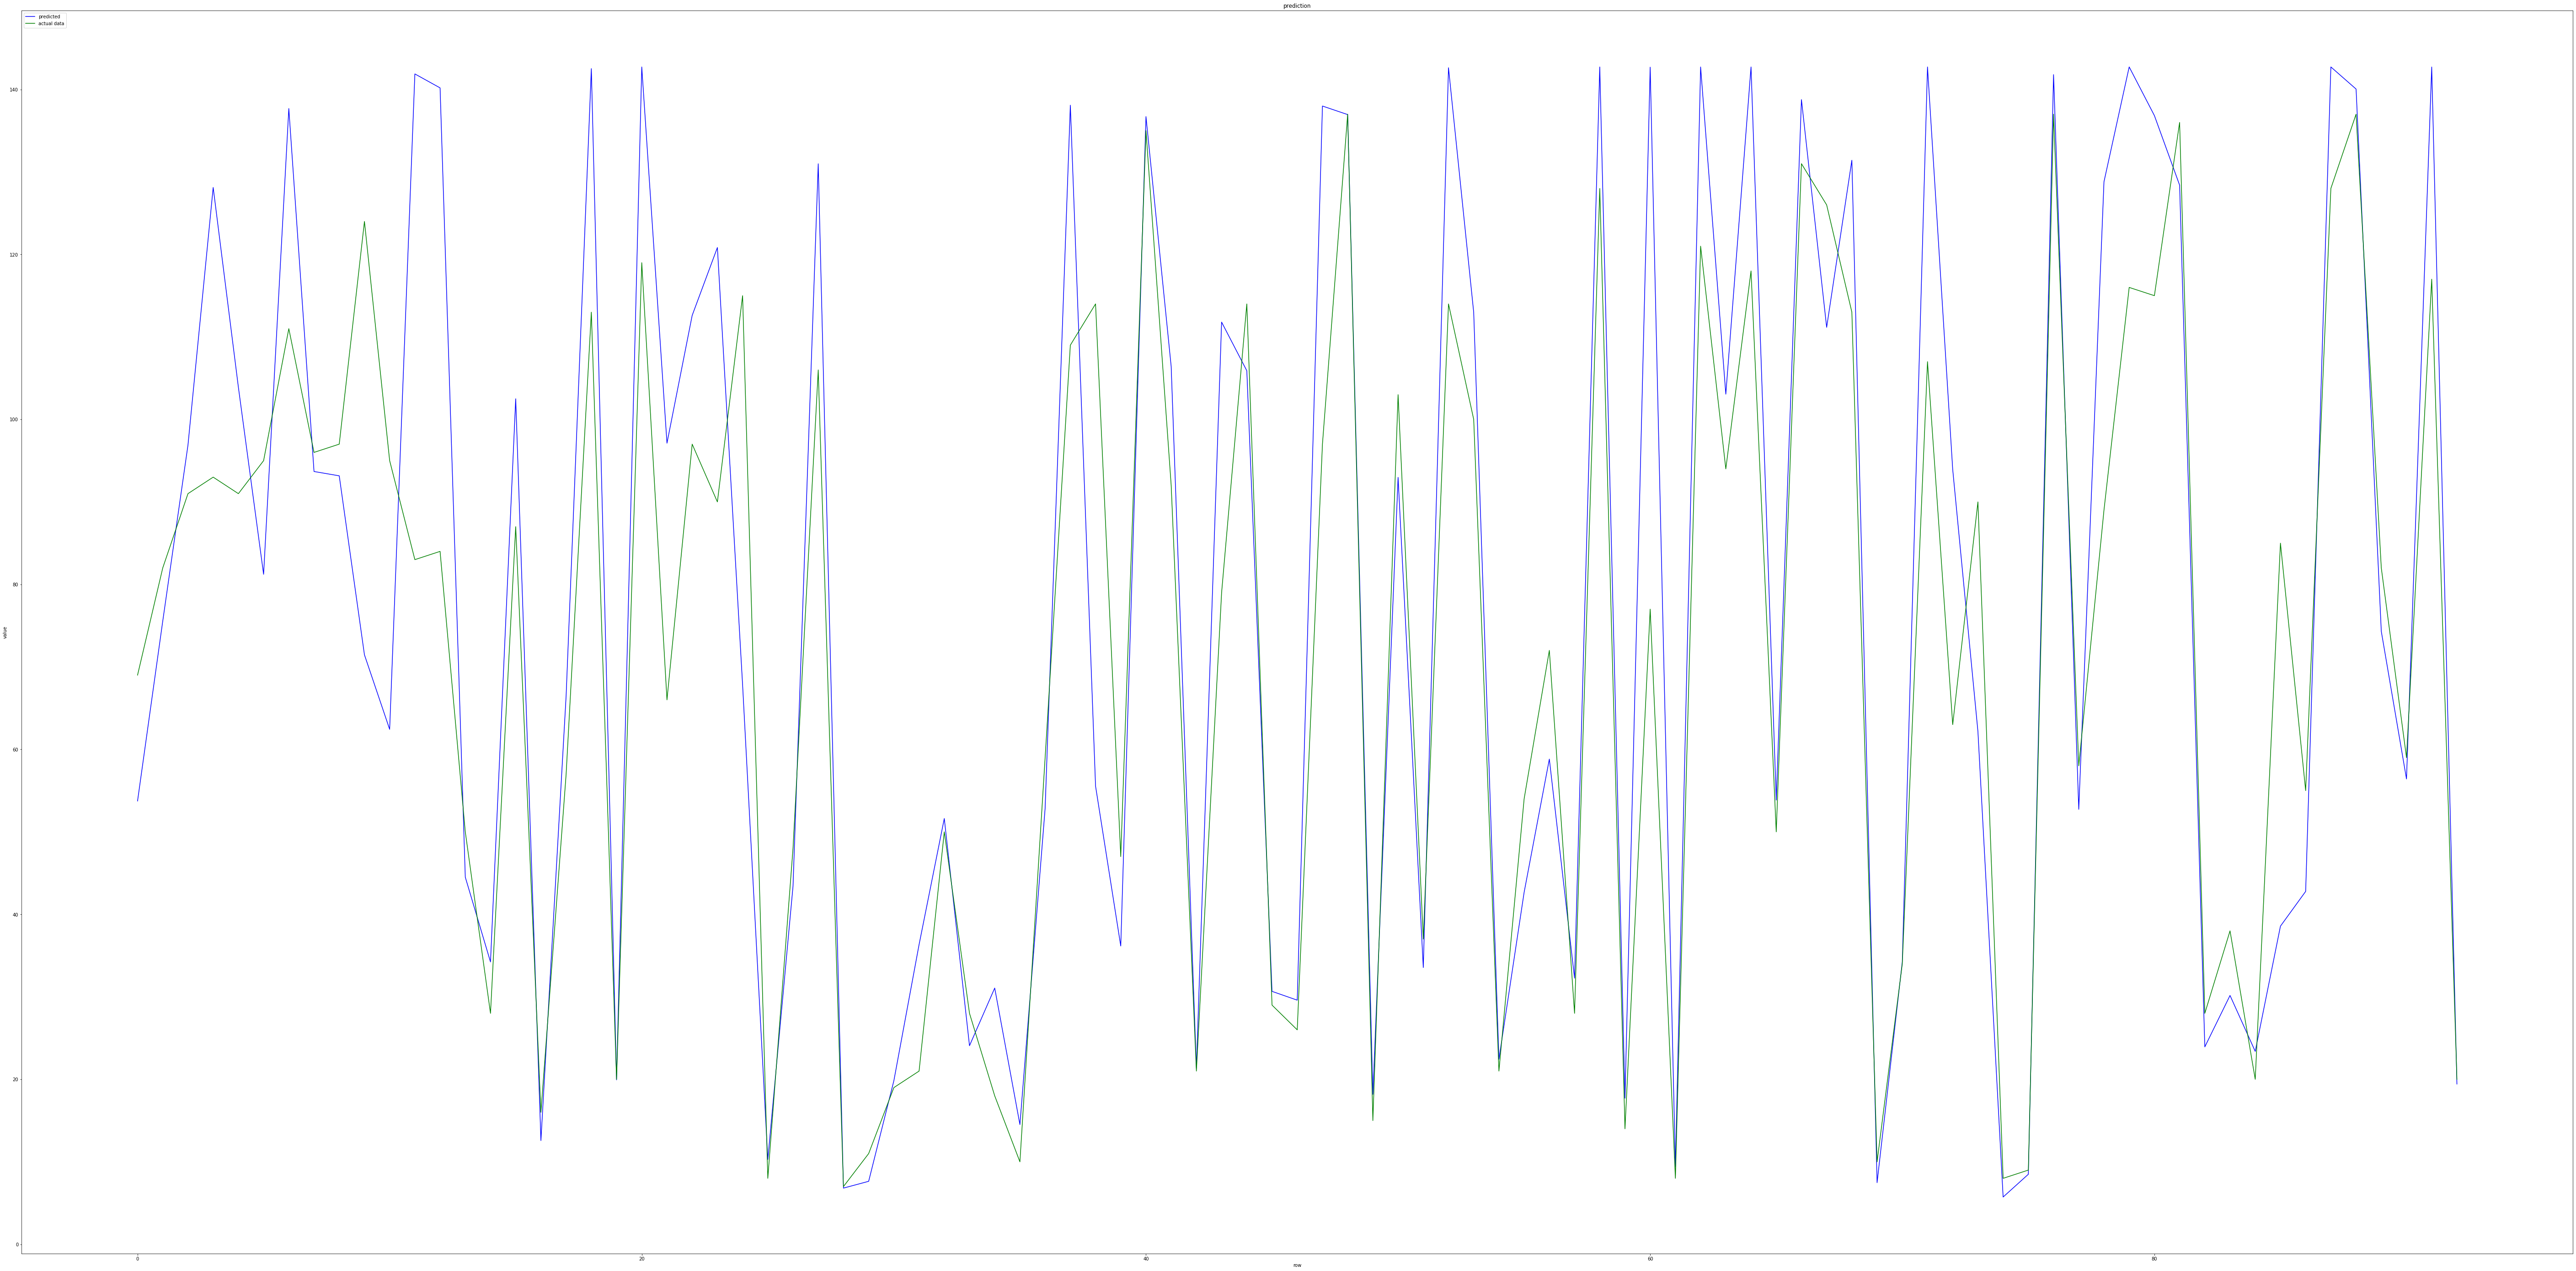

In [0]:
#predict

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(encoded_data_test, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(encoded_data_test)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv(output_path+'/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(100, 50))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig(output_path+"/model_regression_verify.png")

In [0]:

x = np.arange(len(y_pred_test))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(100, 50))
rects1 = ax.bar(x - width/2, y_pred_test.flatten().round(), width, label='predicted')
rects2 = ax.bar(x + width/2, y_true_test.flatten(), width, label='true')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('value')
ax.set_title('prediction')
ax.set_xticks(x)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()
fig.savefig(output_path+"/model_verify_bar.png")

In [36]:
##################################
# Modeling TEST 2 100 units, dropout 0,2
##################################


timesteps = encoded_data.shape[1]
nb_features = encoded_data.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(timesteps, nb_features),
         units=100,
         return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(encoded_data, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path2,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               46000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 14s - loss: 8112.9135 - mean_absolute_error: 71.0288 - r2_keras: -1.5028e+00 - val_loss: 7234.0711 - val_mean_absolute_error: 66.5194 - val_r2_keras: -2.0172e+00
Epoch 2/100
 - 11s

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_r2_keras', 'loss', 'mean_absolute_error', 'r2_keras'])


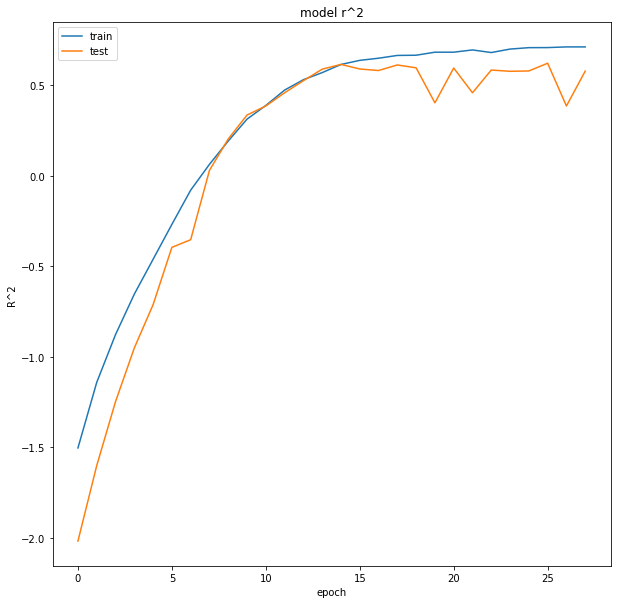

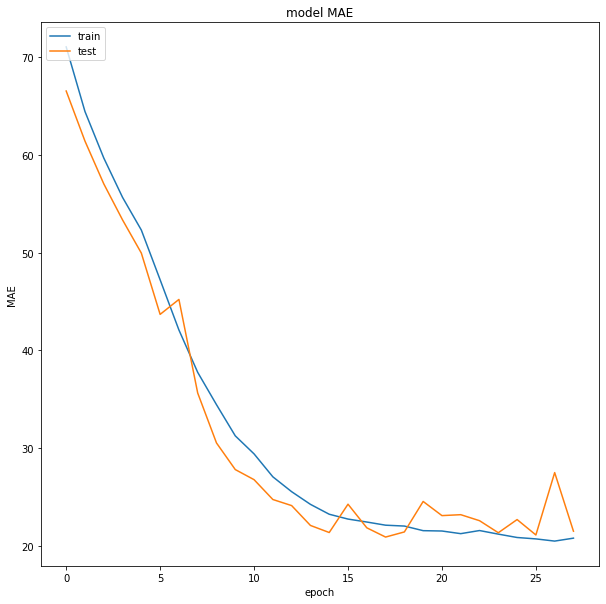

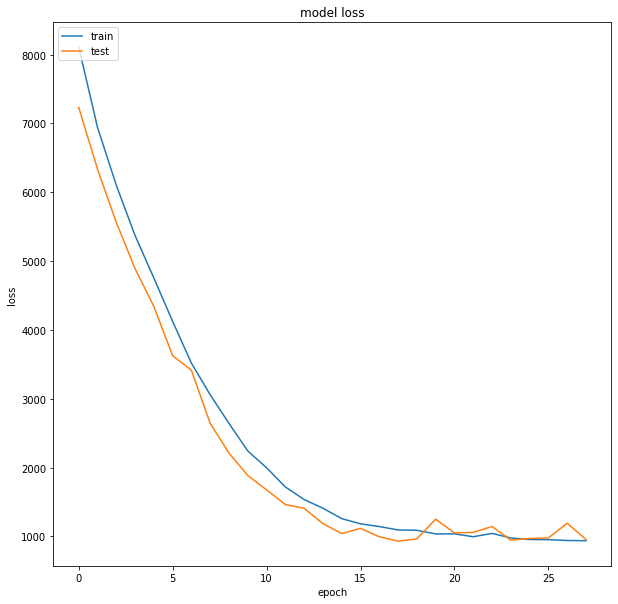

15631/15631 [==============================] - 3s 192us/step

MAE: 19.05364855041538

R^2: 0.6872282482888143
15631/15631 [==============================] - 4s 241us/step


In [37]:
# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path2+"/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path2+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path2+"/model_regression_loss.png")

# training metrics
scores = model.evaluate(encoded_data, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(encoded_data,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv(output_path2+'/submit_train.csv', index = None)

seq_array_test_last
(93, 50, 25)
(93, 1)
93/93 [==============================] - 1s 10ms/step

MAE: 14.357305403678648

R^2: 0.7328173838635926


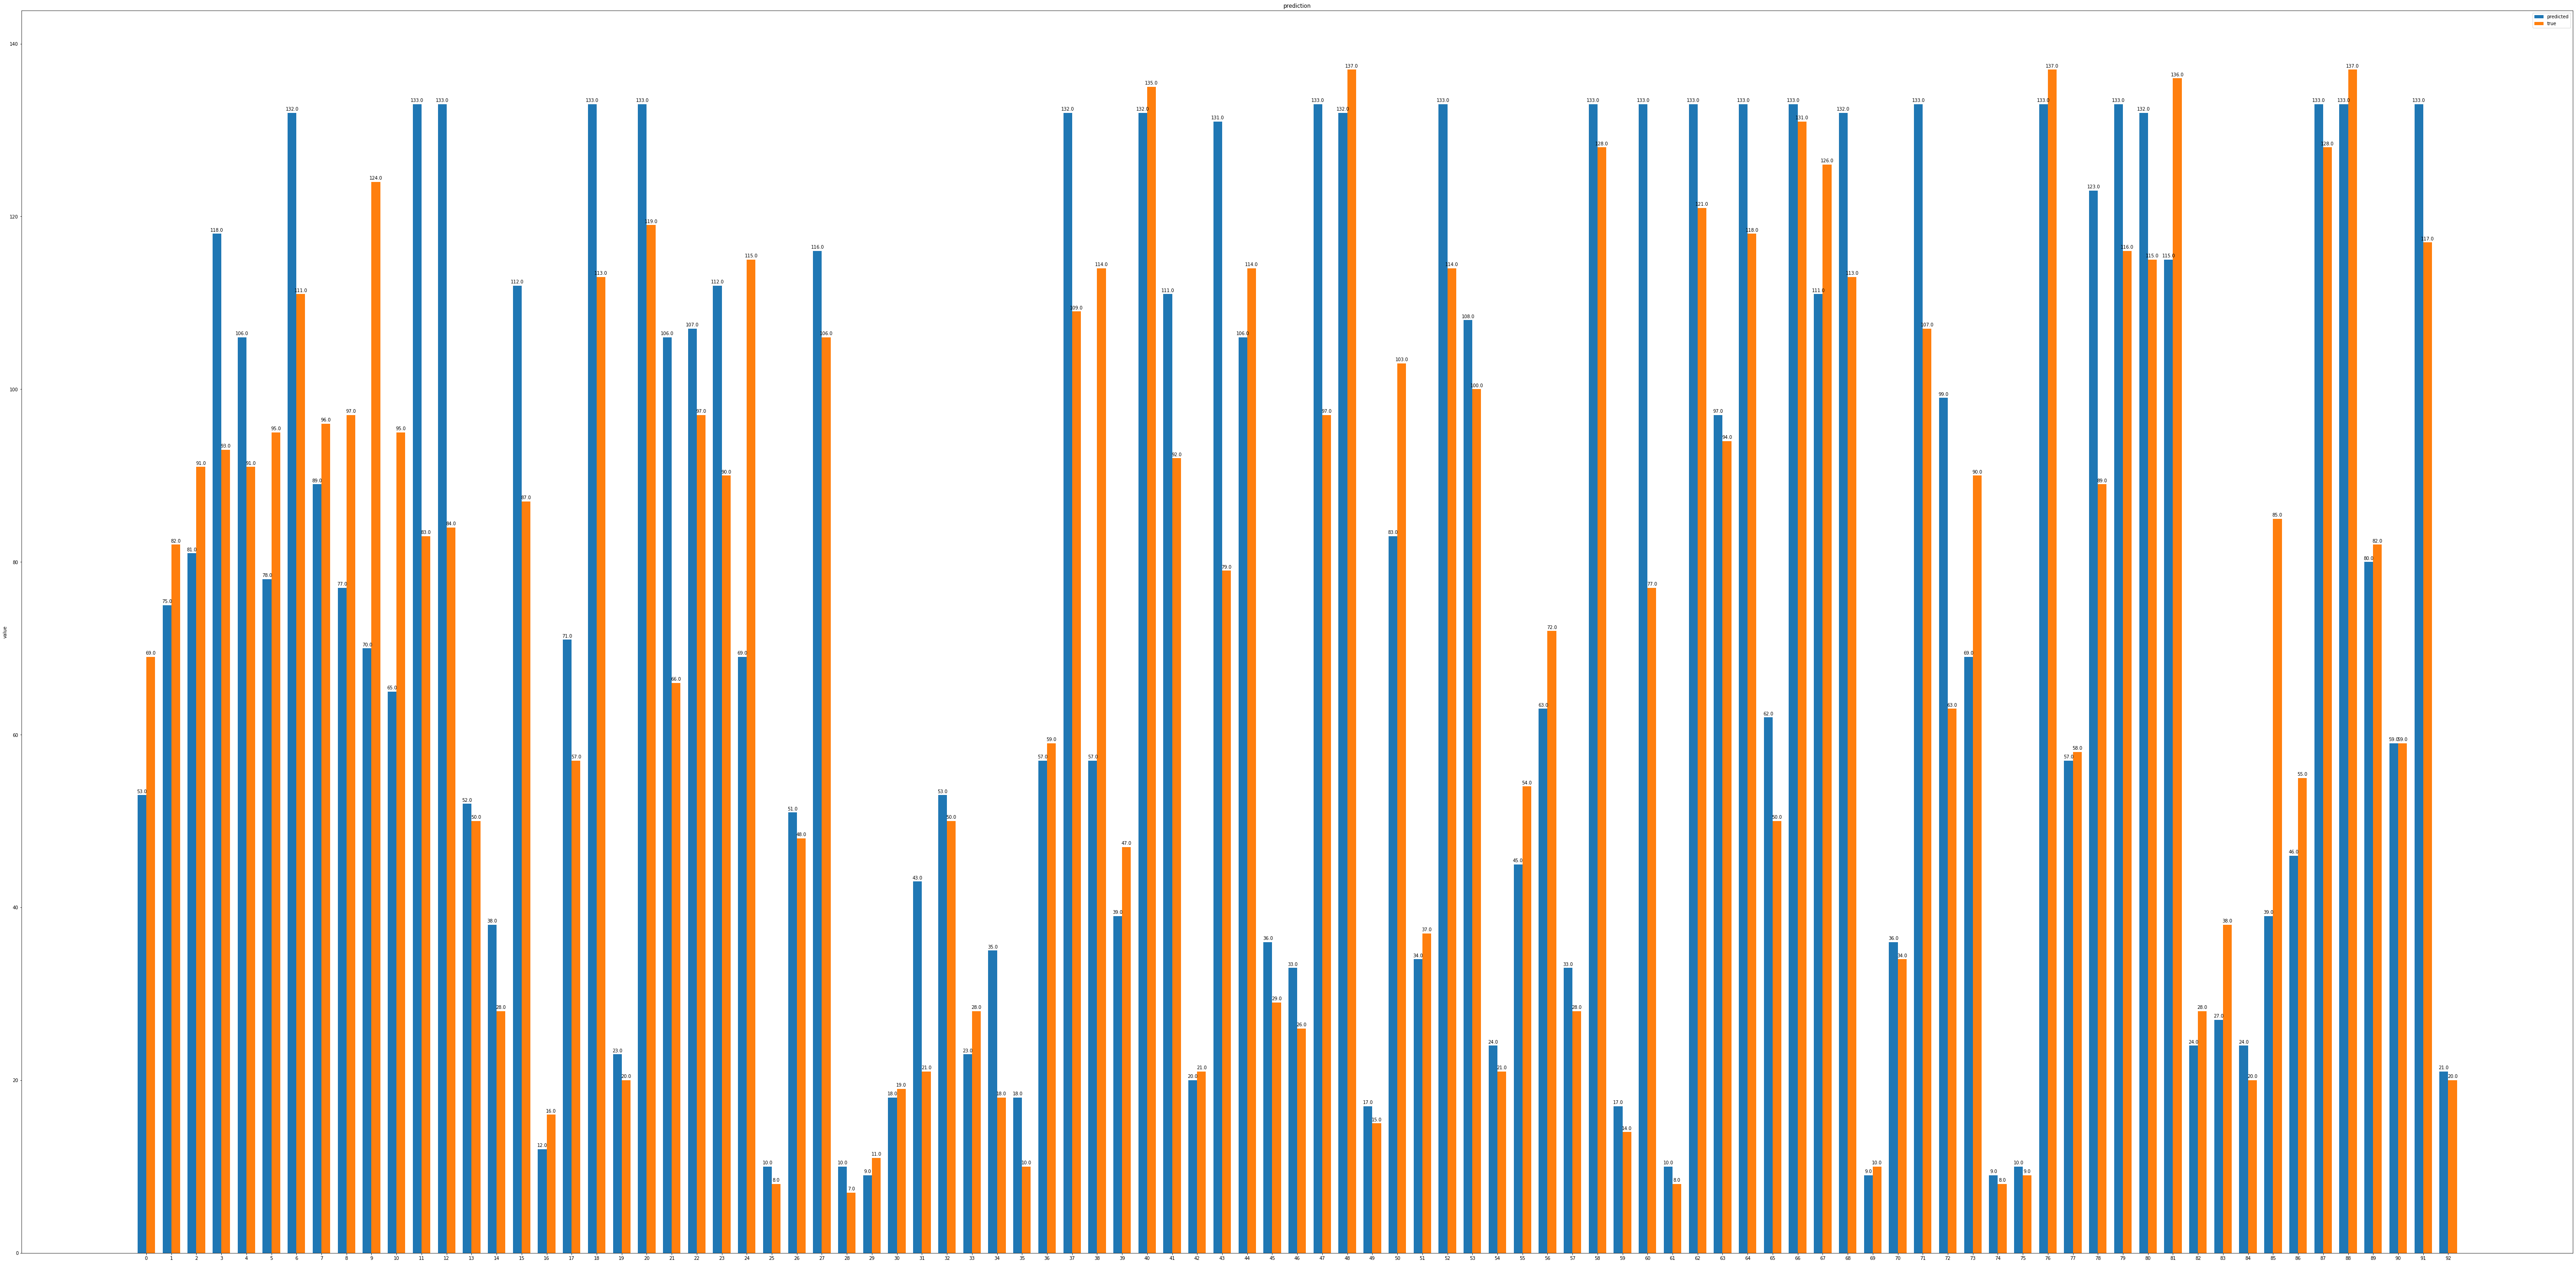

In [38]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

#encode test data

if os.path.isfile(model_path_encoder):
    autoencoder_model = load_model(model_path_encoder,custom_objects={'r2_keras': r2_keras})
    estimator_encoder = Model(inputs=autoencoder_model.inputs, outputs=autoencoder_model.layers[2].output)

    encoded_data_test = estimator_encoder.predict(seq_array_test_last,verbose=1, batch_size=200)
    encoded_data_test.shape

#predict

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path2):
    estimator = load_model(model_path2,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(encoded_data_test, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(encoded_data_test)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv(output_path2+'/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in orange color the
    # actual data to verify visually the accuracy of the model.
        
    x = np.arange(len(y_pred_test))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(100, 50))
    rects1 = ax.bar(x - width/2, y_pred_test.flatten().round(), width, label='predicted')
    rects2 = ax.bar(x + width/2, y_true_test.flatten(), width, label='true')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('value')
    ax.set_title('prediction')
    ax.set_xticks(x)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    plt.show()
    fig.savefig(output_path2+"/model_verify_bar.png")

In [48]:
##################################
# Modeling TEST 2 100 units, dropout 0,2
##################################


timesteps = encoded_data.shape[1]
nb_features = encoded_data.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(timesteps, nb_features),
         units=50,
         return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(encoded_data, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path3,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_11 (Activation)   (None, 1)                 0         
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________
None
Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 9s - loss: 9192.4589 - mean_absolute_error: 77.3732 - r2_keras: -1.8371e+00 - val_loss: 8504.5381 - val_mean_absolute_error: 73.8918 - val_r2_keras: -2.6200e+00
Epoch 2/100
 - 5s 

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_r2_keras', 'loss', 'mean_absolute_error', 'r2_keras'])


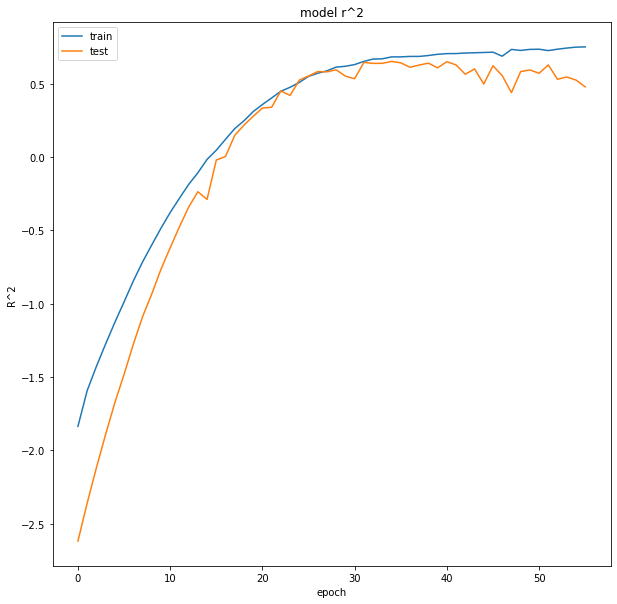

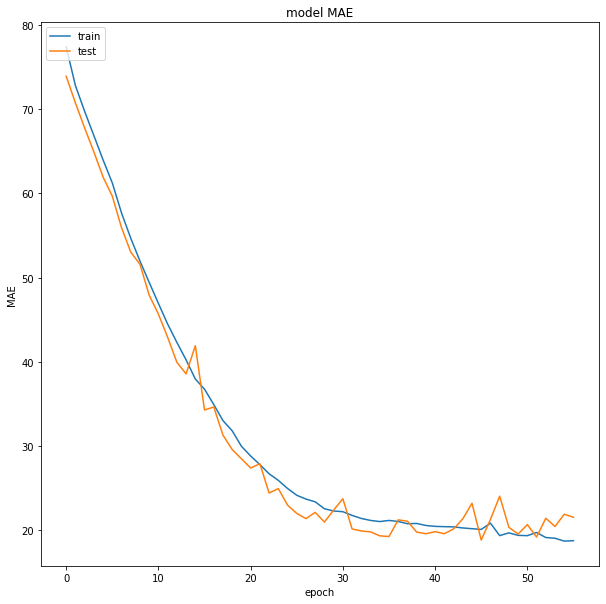

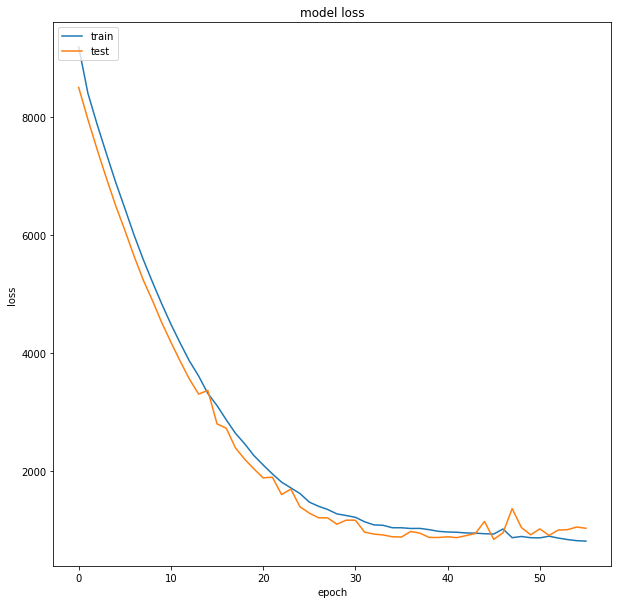

15631/15631 [==============================] - 1s 93us/step

MAE: 17.93653832567332

R^2: 0.6871574720687506
15631/15631 [==============================] - 3s 182us/step


In [49]:
# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path3+"/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path3+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path3+"/model_regression_loss.png")

# training metrics
scores = model.evaluate(encoded_data, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(encoded_data,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv(output_path3+'/submit_train.csv', index = None)

seq_array_test_last
(93, 50, 25)
(93, 1)
93/93 [==============================] - 1s 16ms/step

MAE: 14.558566390827139

R^2: 0.7269390110046633


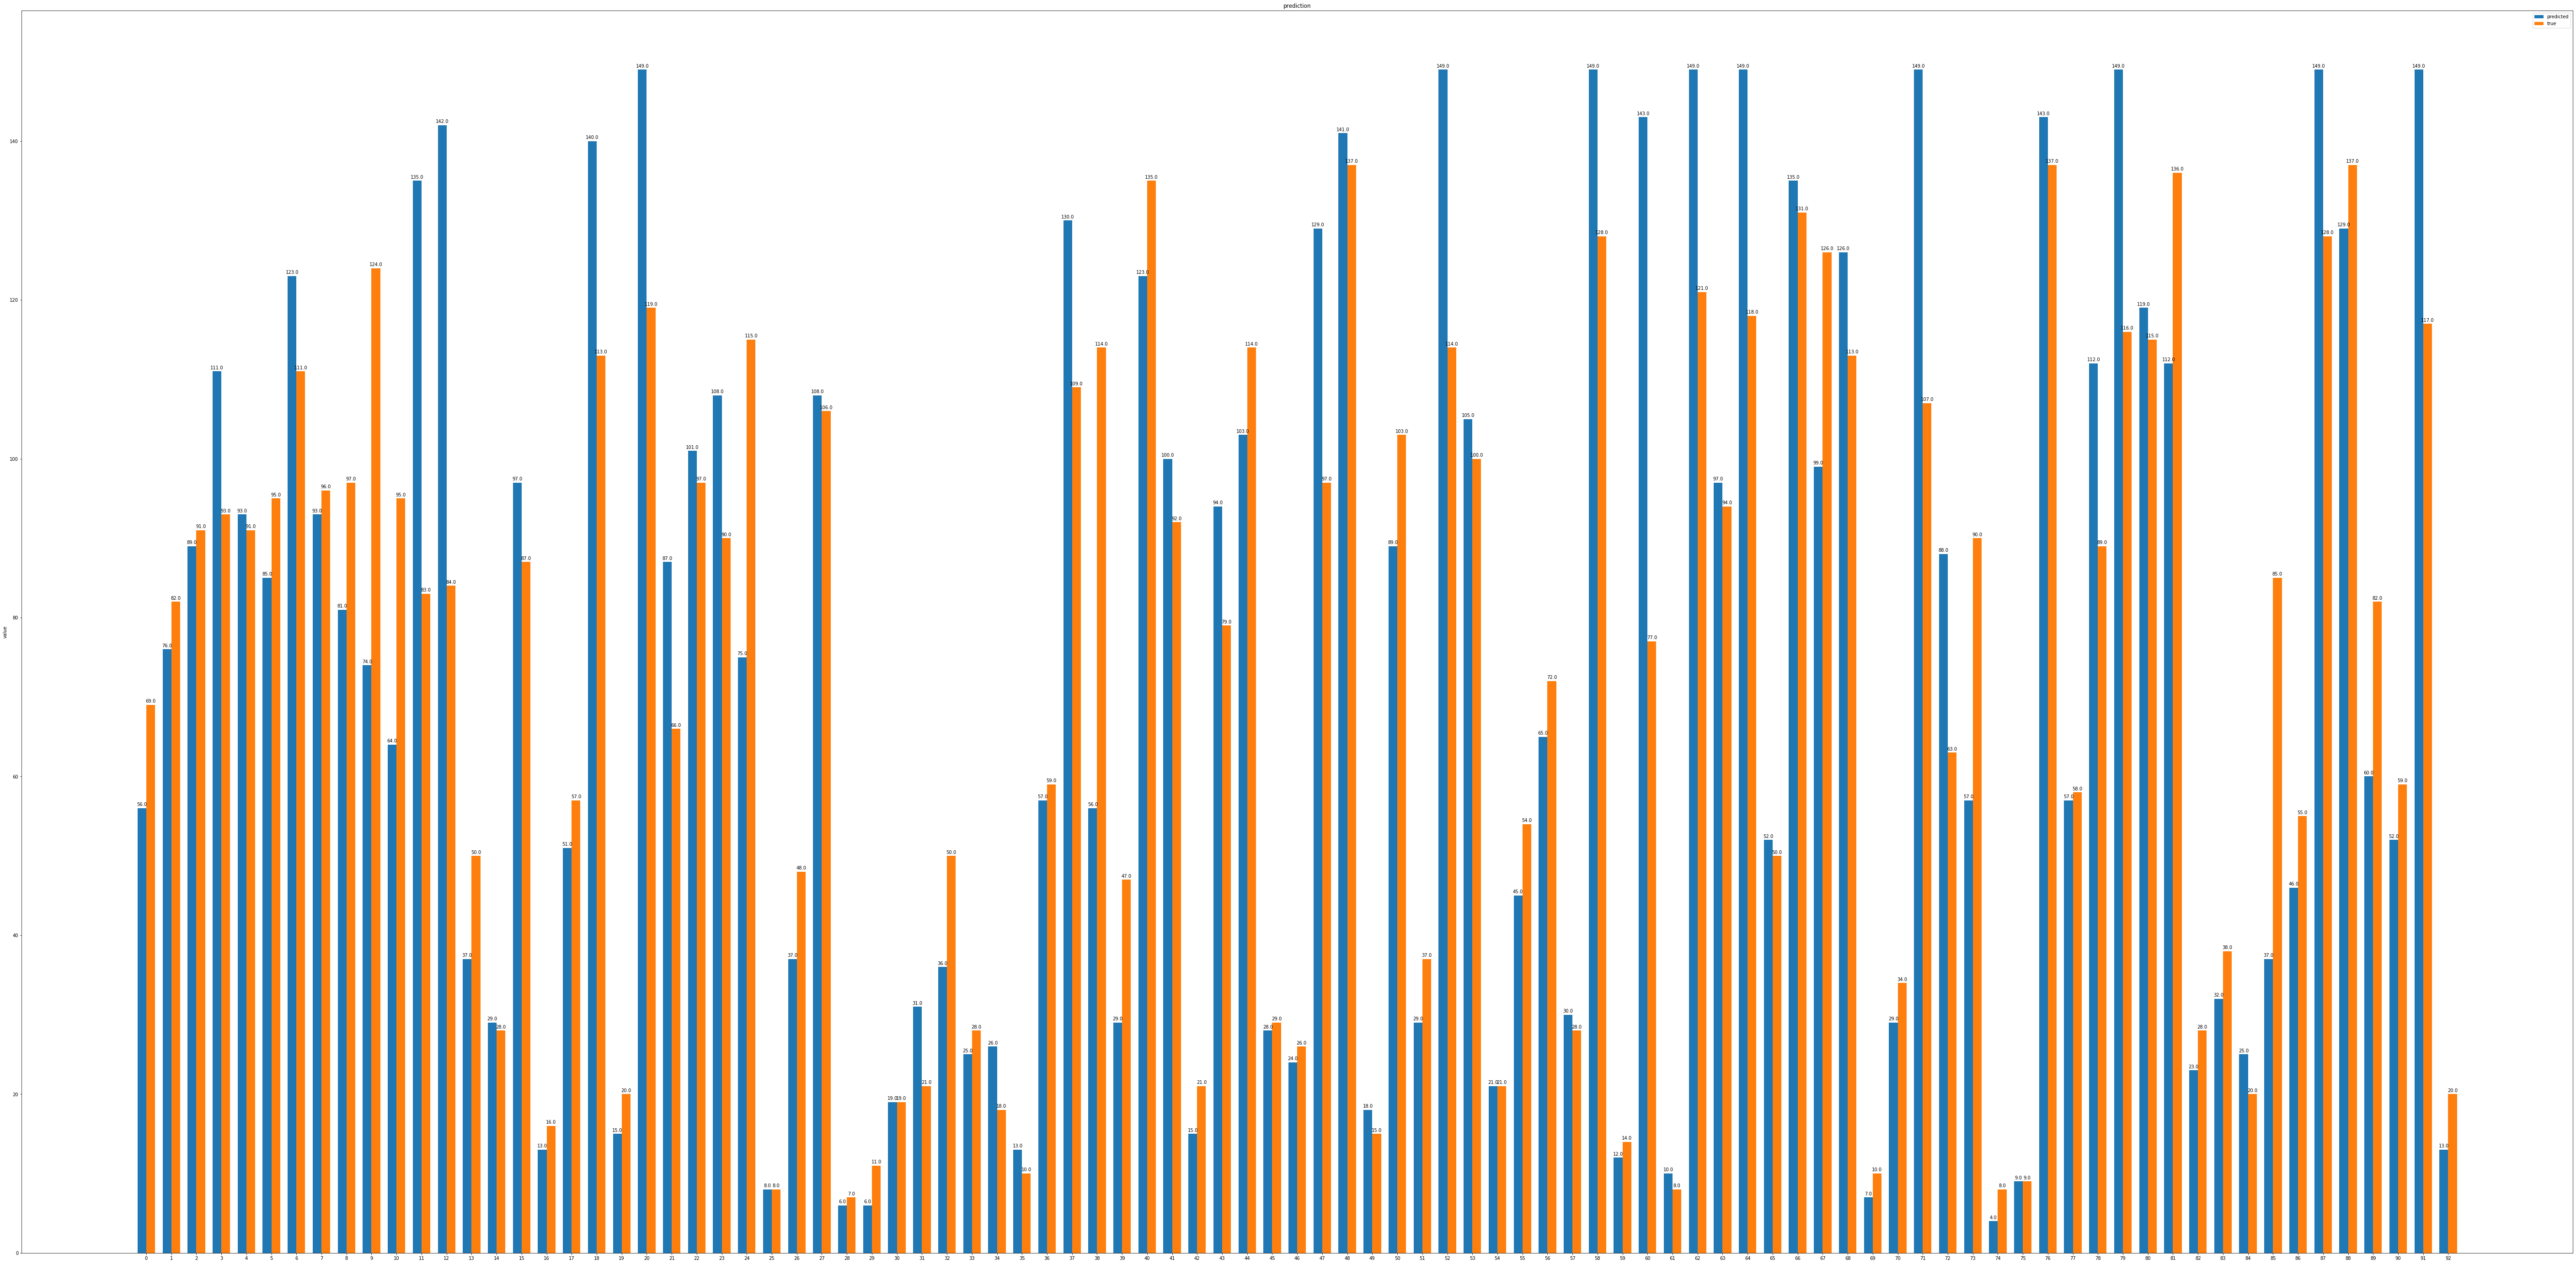

In [50]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

#encode test data

if os.path.isfile(model_path_encoder):
    autoencoder_model = load_model(model_path_encoder,custom_objects={'r2_keras': r2_keras})
    estimator_encoder = Model(inputs=autoencoder_model.inputs, outputs=autoencoder_model.layers[2].output)

    encoded_data_test = estimator_encoder.predict(seq_array_test_last,verbose=1, batch_size=200)
    encoded_data_test.shape

#predict

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path3):
    estimator = load_model(model_path3,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(encoded_data_test, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(encoded_data_test)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv(output_path3+'/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in orange color the
    # actual data to verify visually the accuracy of the model.
        
    x = np.arange(len(y_pred_test))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(100, 50))
    rects1 = ax.bar(x - width/2, y_pred_test.flatten().round(), width, label='predicted')
    rects2 = ax.bar(x + width/2, y_true_test.flatten(), width, label='true')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('value')
    ax.set_title('prediction')
    ax.set_xticks(x)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    plt.show()
    fig.savefig(output_path3+"/model_verify_bar.png")